<a href="https://colab.research.google.com/github/ekodavidkurnia/AI-Assistant-Lecturer-2021/blob/master/Chest_X_Ray_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
# Get the helper function
!wget https://raw.githubusercontent.com/ekodavidkurnia/AI-Assistant-Lecturer-2021/master/helper_functions.py

--2021-12-01 09:58:11--  https://raw.githubusercontent.com/ekodavidkurnia/AI-Assistant-Lecturer-2021/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-01 09:58:12 (55.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [21]:
train_dir = "/content/drive/MyDrive/Dataset/chest_xray/train"
val_dir = "/content/drive/MyDrive/Dataset/chest_xray/val"
test_dir = "/content/drive/MyDrive/Dataset/chest_xray/test"

In [6]:
# How many images/classes are there?
walk_through_dir(train_dir)

There are 2 directories and 0 images in '/drive/MyDrive/Dataset/chest_xray/train'.
There are 0 directories and 3891 images in '/drive/MyDrive/Dataset/chest_xray/train/PNEUMONIA'.
There are 0 directories and 1350 images in '/drive/MyDrive/Dataset/chest_xray/train/NORMAL'.


In [25]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 5241 files belonging to 2 classes.
Found 634 files belonging to 2 classes.


In [22]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 16 files belonging to 2 classes.


In [8]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [9]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="sigmoid", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [10]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable

In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history = model.fit(train_data,
                   epochs=5, # fit for 5 epochs to keep experiments quick
                   validation_data=test_data,
                   validation_steps=int(0.15 * len(test_data))) #, # evaluate on smaller portion of test data
                                           #callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
164/164 [==============================] - 480s 3s/step - loss: 0.2521 - accuracy: 0.8952 - val_loss: 0.6302 - val_accuracy: 0.6562
Epoch 2/5
164/164 [==============================] - 63s 376ms/step - loss: 0.1739 - accuracy: 0.9334 - val_loss: 0.3262 - val_accuracy: 0.8854
Epoch 3/5
164/164 [==============================] - 60s 353ms/step - loss: 0.1531 - accuracy: 0.9418 - val_loss: 0.3857 - val_accuracy: 0.8750
Epoch 4/5
164/164 [==============================] - 55s 325ms/step - loss: 0.1460 - accuracy: 0.9445 - val_loss: 0.1810 - val_accuracy: 0.9479
Epoch 5/5
164/164 [==============================] - 54s 317ms/step - loss: 0.1498 - accuracy: 0.9412 - val_loss: 0.1645 - val_accuracy: 0.9688


In [23]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(val_data)
results_feature_extraction_model

1/1 [==============================] - 2s 2s/step - loss: 0.2177 - accuracy: 0.9375


[0.2176501750946045, 0.9375]

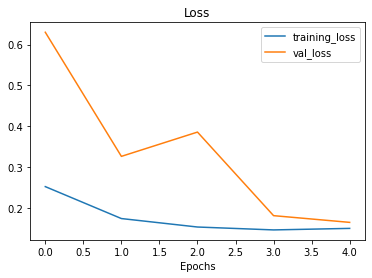

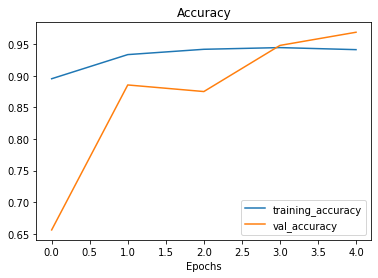

In [18]:
plot_loss_curves(history)

In [26]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

20/20 [==============================] - 48s 2s/step


In [27]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
pred_classes[:-10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [29]:
# Note: This might take a minute 
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
y_labels[:-10]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [31]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.8738170347003155

In [32]:
from helper_functions import make_confusion_matrix

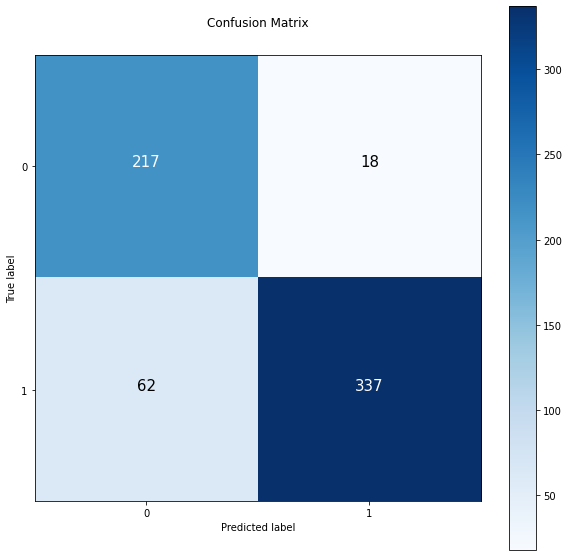

In [33]:
make_confusion_matrix(y_labels, pred_classes)